## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('MelGAN')
import numpy as np
import torch

from hparams import create_hparams
from model.tacotron import Tacotron2
from train import load_model
from text import text_to_sequence
from MelGAN.infer import MelGAN

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [4]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load MelGAN for mel2audio synthesis

In [5]:
# MelGAN vocoder (currently using Multi-Band MelGAN)
melGAN = MelGAN()
melGAN.initialize('vctk/checkpoint-1000000steps.pkl')

#### Prepare text input

In [6]:
text = "zhe4-duo3-huar1 zhen1 shi4 tai4-mei3-le5, This paper proposes a new gee pee tee two model!"
sequence = np.array(text_to_sequence(text, ['basic_cleaners'], 'en'))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

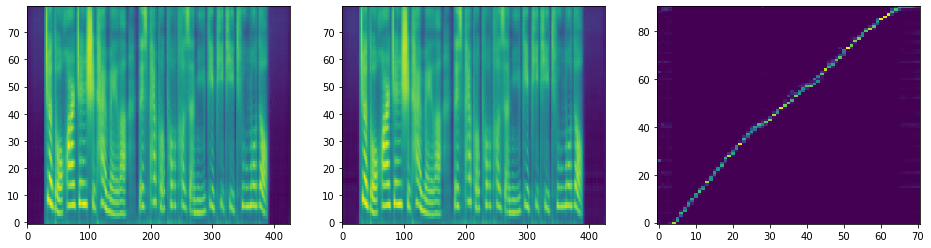

In [7]:
speaker = [6]
speaker = torch.from_numpy(np.array(speaker)).cuda().long()
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence, speaker)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using MelGAN

In [8]:
mels = mel_outputs_postnet.transpose(1, 2).data.cpu().numpy()
audios = melGAN.infers(mels)
ipd.Audio(audios[0], rate=hparams.sampling_rate)